1. linreg for EGTM, 1 engine only
2. tune theta degree
3. tune altitude + bleed ensemble

In [87]:
from deltas import *

bdu_all = pd.read_csv('./takeoff-merged-VQ-BDU-30s.csv', parse_dates=['reportts']).query('pos == 2')
bdu_all = correct(bdu_all)

Setup the experiment:

### 1. Gridsearch of x/y/theta variants

In [88]:
best_rmse = 1000
best_model = None
best_pred = None
best_x, best_y, best_th = None, None, None

alpha = 0.5
alpha_2 = 0.884

x_variants = [\
  'n1', 'n1a', 'n1com', 'n1c2', 'n2a', 'n2c5',
  'n2p', 'nf', 'n1_peak', 'n1msa', 'n1p',
  'n1a_peak', 'n1c2_peak', 'n1com_peak', 
  'n1max', 'n1max_peak', 'n2a_peak', 'nf_peak']

y_variants = ['egt', 'egt_peak', 'egtb']

theta_variants = ['oat', 'oat_peak', 't14', 't2', 't25', 't2_peak', 'tat', 'tat_rtd', 'tn', 'tat_peak']

hall_of_fame = []

tat_peak = правильный

In [9]:
def theta_correct(data, x_param, y_param, theta_param, alpha2 = alpha_2):
  theta = (data[theta_param] + 273.16) / (288.16 * (1.0 + 0.2 * data['mn_peak'] ** 2))
  data[f'{y_param}_k'] = (data[y_param] + 273.16) / (theta ** alpha2)
  data[f'{x_param}_k'] = data[x_param] / (theta ** alpha)
  return data

In [10]:

def combination_to_number (comb: tuple[bool]):
    a = map(int, comb)
    return int(''.join(map(str, a)))


combination_to_number((True, False, True)), combination_to_number((False, False, False))


(101, 0)

In [125]:
from sklearn.base import BaseEstimator, RegressorMixin
import itertools

class EGTMarginRegressor(BaseEstimator, RegressorMixin):
    def __init__(
            self, 
            fleet = [],
            x_param = 'n1a_peak',
            y_param = 'egt_peak',
            theta_param = 'tat_peak',
            bleed_config = ['prv'],
            alt_split = None,
            early_range = [50, 200],
            theta_alpha = alpha_2,
        ):
        self.fleet = fleet
        self.x_param = x_param
        self.y_param = y_param
        self.theta_param = theta_param
        self.bleed_config = bleed_config
        self.alt_split = alt_split
        self.early_range = early_range
        self.theta_alpha = theta_alpha
        self.smooth_factor = 0.05

    def _get_bleed_filter_index(self, X, comb: tuple[bool]):
        index = True
        assert len(comb) == len(self.bleed_config)
        for i in range(len(self.bleed_config)):
            field_name = self.bleed_config[i]
            index = index & (X[field_name] == comb[i])
        return index
    
    def fit(self, X, y):
        Xk = theta_correct(X, self.x_param, self.y_param, self.theta_param, alpha2=self.theta_alpha)
        x_param_k, y_param_k = f'{self.x_param}_k', f'{self.y_param}_k'
        start, end = self.early_range

        # *separate* baseline for each bleed config
        # later try single baseline for engine 
        # but fit linreg to each bleed conf separately
        self.ensemble = dict()
        self.baselines = dict()

        for comb in itertools.product([True,False], repeat=len(self.bleed_config)):
            index = self._get_bleed_filter_index(Xk, comb)
            Xf, yf = Xk[index], y[index]

            baseline = train_engine_baseline(Xf[start:end], x_param_k, y_param_k)
            egtm_base = compute_egtm(Xf[start:end], baseline, x_param_k, y_param_k)

            lin_model = LinearRegression()
            smooth_base_egtm = pd.DataFrame(smooth(egtm_base, self.smooth_factor), columns=['egt_peak_k'])
            lin_model.fit(smooth_base_egtm, yf[start:end])

            n = combination_to_number(comb)
            self.ensemble[n] = lin_model
            self.baselines[n] = baseline

        return self
        
    def predict(self, X):
        pred = pd.DataFrame(index=X.index.copy(), columns=['pred'])
        x_param_k, y_param_k = f'{self.x_param}_k', f'{self.y_param}_k'
        Xk = theta_correct(X, self.x_param, self.y_param, self.theta_param, alpha2=self.theta_alpha)
        
        for comb in itertools.product([True,False], repeat=len(self.bleed_config)):
            n = combination_to_number(comb)
            index = self._get_bleed_filter_index(Xk, comb)
            Xf = Xk[index]
            baseline = self.baselines[n]
        
            egtm = compute_egtm(Xf, baseline, x_param_k, y_param_k)
            X = pd.DataFrame(egtm)

            model = self.ensemble[n]
            pp = model.predict(X)
            pred.loc[index, 'pred'] = pp

        return pred
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, smooth(y_pred['pred'], self.smooth_factor))


In [119]:
bgu_all = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']) \
  .query('pos == 2 and reportts >= "2019-01-05"')
bgu_all.shape

(804, 212)

fit  Index(['egt_peak_k'], dtype='object') (240, 1)
fit  Index(['egt_peak_k'], dtype='object') (240, 1)
predict  Index(['egt_peak_k'], dtype='object')
predict  Index(['egt_peak_k'], dtype='object')
predict  Index(['egt_peak_k'], dtype='object')
predict  Index(['egt_peak_k'], dtype='object')
0.9641147497233676


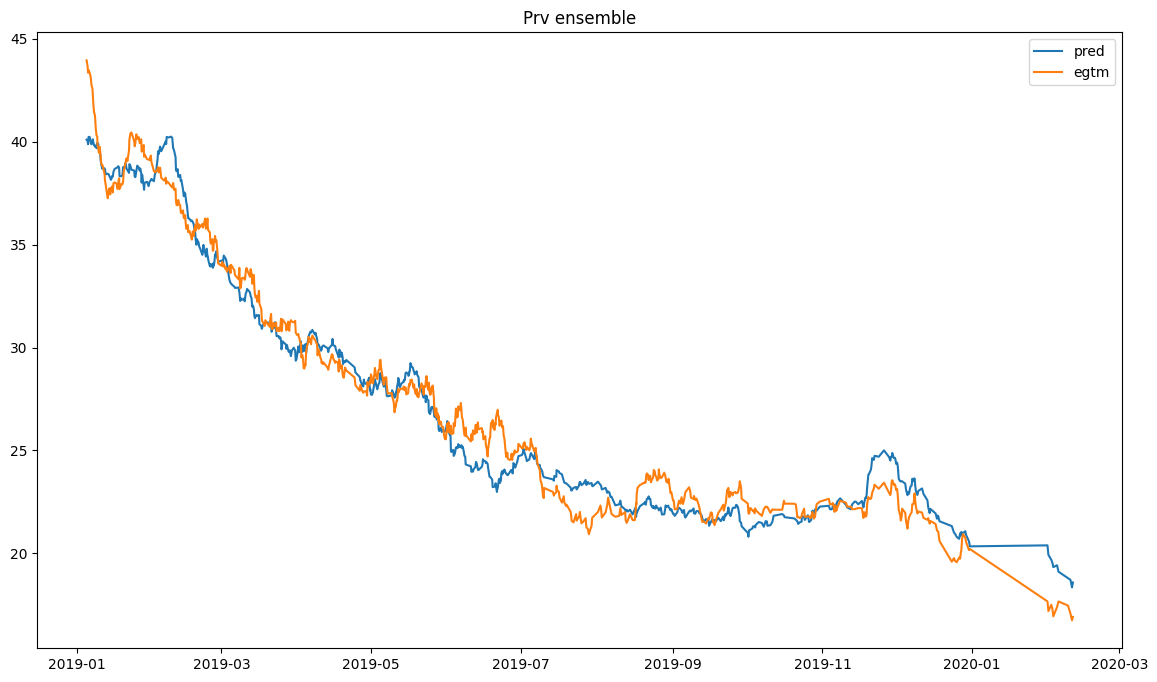

In [126]:
model = EGTMarginRegressor(early_range=[10, 250])
bdu = bdu_all.query(f"n2a_peak > 0 and egt_peak > 0 and tat > -100 and egtm > -100").copy()
bgu = bgu_all.query(f"n2a_peak > 0 and egt_peak > 0 and tat > -100 and egtm > -100").copy()

model.fit(bgu, bgu['egtm'])
pred = model.predict(bgu)

print(model.score(bgu, bgu['egtm']))

plt.figure(figsize=(14, 8))
plt.title(f'Prv ensemble')
plt.plot(bgu['reportts'], smooth(pred['pred'], 0.05))
plt.plot(bgu['reportts'], bgu['egtm'])
plt.legend(['pred', 'egtm'])
plt.show()

In [90]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

for x_param in x_variants:
  for y_param in y_variants:
    for theta_param in theta_variants:
      bdu = bdu_all.query(f"{x_param} > 0 and {y_param} > 0 and {theta_param} > -100 and egtm > -100").copy()
      x_param_k, y_param_k = f'{x_param}_k', f'{y_param}_k'
      bdu = theta_correct(bdu, x_param, y_param, theta_param)
      assert bdu.shape[0] >= 250
      baseline = train_engine_baseline(bdu[50:250], x_param_k, y_param_k)
      egtm = compute_egtm(bdu, baseline, x_param_k, y_param_k)

      X = pd.DataFrame(smooth(egtm, 0.05))
      lin_model = LinearRegression()
      lin_model.fit(X, y=bdu['egtm'])

      pred = lin_model.predict(X)
      
      rmse = root_mean_squared_error(bdu['egtm'], pred)

      if rmse < best_rmse:
        best_pred = pred
        best_rmse = rmse
        best_model = lin_model
        best_x, best_y, best_th = x_param, y_param, theta_param

      hall_of_fame.append({
        'x_param': x_param,
        'y_param': y_param, 
        'theta_param': theta_param,
        'rmse': rmse
      })


In [6]:
pd.DataFrame(hall_of_fame).sort_values('rmse')[:10]

,x_param,y_param,theta_param,rmse
819,n2a_peak,egt_peak,t14,0.830892
822,n2a_peak,egt_peak,t2_peak,0.854996
826,n2a_peak,egt_peak,tat_peak,0.865870
818,n2a_peak,egt_peak,oat_peak,0.866610
823,n2a_peak,egt_peak,tat,0.950374
447,n2a,egt,oat,1.026282
454,n2a,egt,tat_rtd,1.037091
448,n2a,egt,oat_peak,1.062510
450,n2a,egt,t2,1.066969
120,n2a,egt,oat,1.079399


#### Plot best result: 

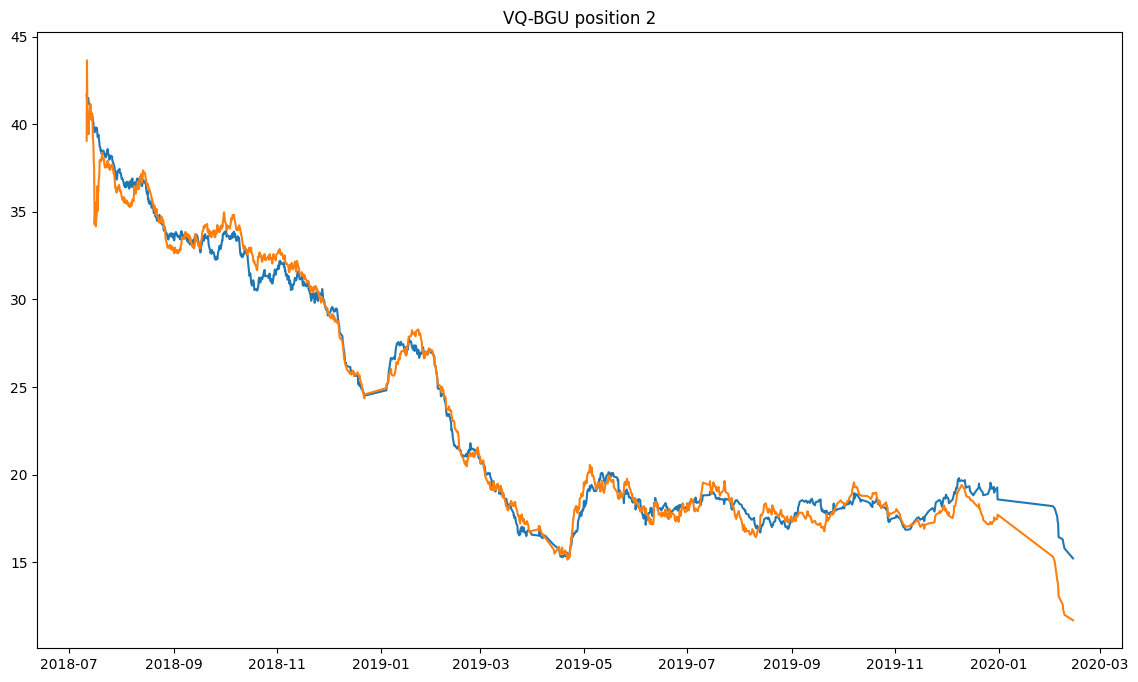

In [7]:
import matplotlib.pyplot as plt

bdu = bdu_all.query(f"n2a_peak > 0 and egt_peak > 0 and tat > -100 and egtm > -100").copy()

plt.figure(figsize=(14, 8))
plt.title(f'VQ-BGU position 2')
plt.plot(bdu['reportts'], best_pred)
plt.plot(bdu['reportts'], bdu['egtm'])
plt.show()

### Finetune coefficient for theta corrections

In [8]:
best_x, best_y, best_th

('n2a_peak', 'egt_peak', 't14')

In [9]:
best_rmse = 1000
best_a = 1000

factor = 10_000

for a in range(8000, 9000, 1):
  bdu = theta_correct(bdu, best_x, best_y, best_th, alpha2=(a / factor))
  x_param_k, y_param_k = f'{best_x}_k', f'{best_y}_k'
  baseline = train_engine_baseline(bdu[:200], x_param_k, y_param_k)
  egtm = compute_egtm(bdu, baseline, x_param_k, y_param_k)

  X = pd.DataFrame(smooth(egtm, 0.05))
  lin_model = LinearRegression()
  lin_model.fit(X, y=bdu['egtm'])

  pred = lin_model.predict(X)
  
  rmse = root_mean_squared_error(bdu['egtm'], pred)

  if rmse < best_rmse:
    best_a = a / factor
    best_rmse = rmse

print(best_a, best_rmse)

0.8825 0.8315689377080188


**Result For VQ-BDU pos 2:**

- `alpha_2 = 0.869 (not 0.84)`
- `x_param = n2a_peak`
- `y_param = egt_peak	`
- `theta_param = tat`

For VQ-BGU results are inconsistent; We try to plot deltas applying corrections same as for VQ-BDU

In [10]:
bgu_all = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']) \
  .query('pos == 2 and reportts >= "2019-01-01"')
bgu_all.shape

(814, 212)

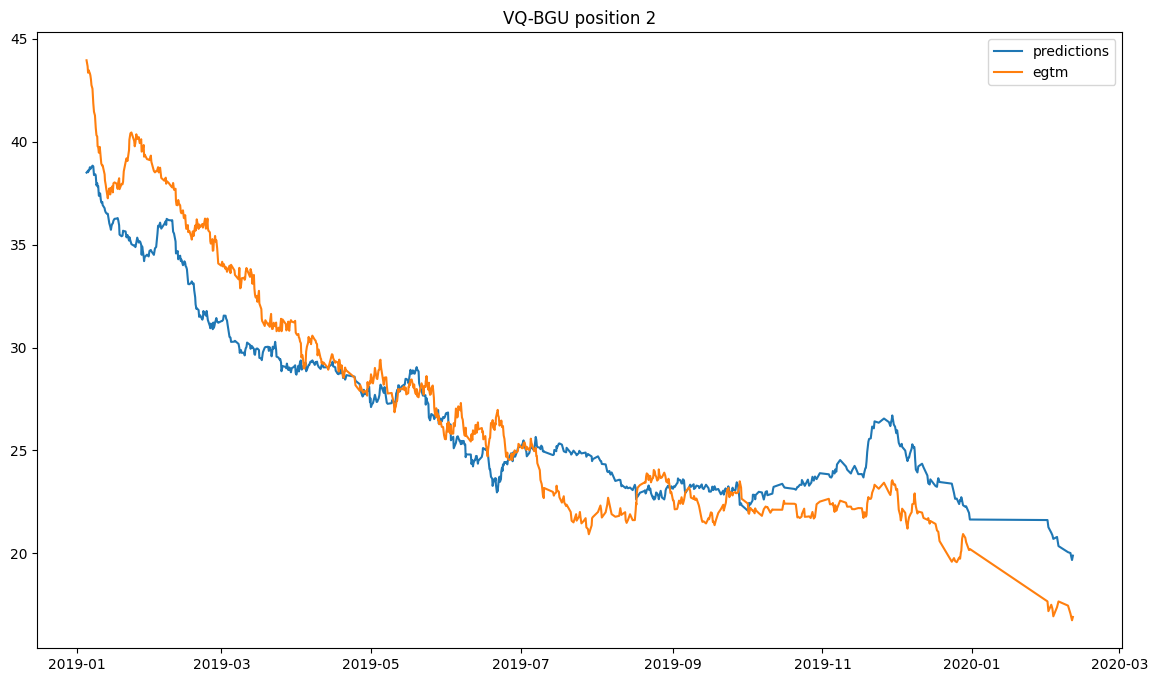

In [92]:
x_param = "n2a_peak"
y_param = "egt_peak"
theta_param = "tat_peak"

bgu = bgu_all.query(f"{x_param} > 0 and {y_param} > 0 and {theta_param} > -100 and egtm > -100").copy()
x_param_k, y_param_k = f'{x_param}_k', f'{y_param}_k'
bgu = theta_correct(bgu, x_param, y_param, theta_param)
assert bgu.shape[0] >= 100
baseline = train_engine_baseline(bgu[:100], x_param_k, y_param_k)
egtm = compute_egtm(bgu, baseline, x_param_k, y_param_k)

X = pd.DataFrame(smooth(egtm, 0.05))
lin_model = LinearRegression()
lin_model.fit(X[:100], y=bgu['egtm'][:100])

pred = lin_model.predict(X)

rmse = root_mean_squared_error(bgu['egtm'], pred)

# bgu = bgu_all.query(f"n2a_peak > 0 and egt_peak > 0 and tat > -100 and egtm > -100").copy()

plt.figure(figsize=(14, 8))
plt.title(f'VQ-BGU position 2')
# plt.plot(bgu['reportts'], pred)
plt.plot(bgu['reportts'], smooth(0.8 * egtm + 7.4, 0.05))
plt.plot(bgu['reportts'], bgu['egtm'])
plt.legend(['predictions', 'egtm'])
plt.show()